In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9] 
import seaborn as sns

In [2]:
# Selecting ES futures on 1hr interval to look at
df = yf.download('ES=F', start="2023-1-04", end="2023-05-03", interval = "1h",)

# Filtering down to just the adjusted close price
df['higher_highs'] = df['High'].shift(1).rolling(144).max()
df['lower_lows'] = df['Low'].shift(1).rolling(144).min()
df.fillna(method='ffill', inplace=True)
df['midpoint'] = (df['higher_highs'] +  df['lower_lows']) / 2

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

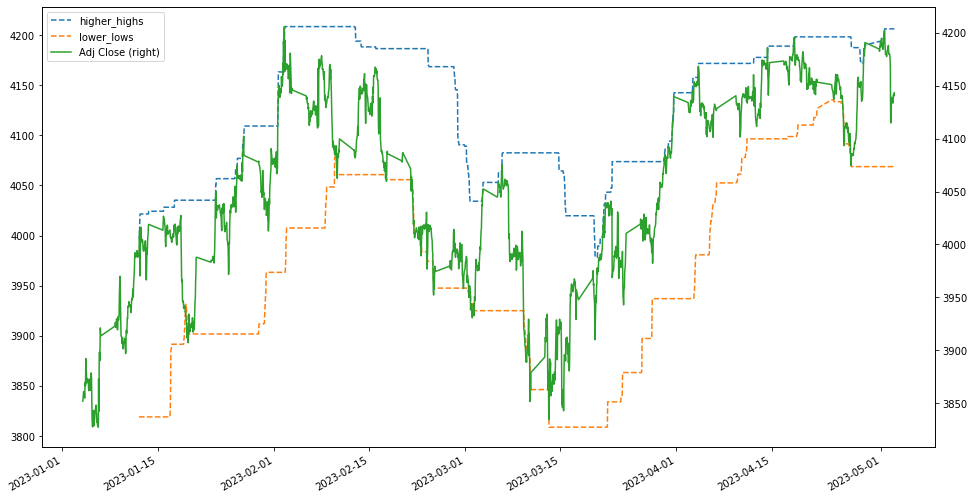

In [3]:
df[['higher_highs', 'lower_lows']].plot(style='--',legend=True)
df['Adj Close'].plot(secondary_y=True,legend=True)

<AxesSubplot:>

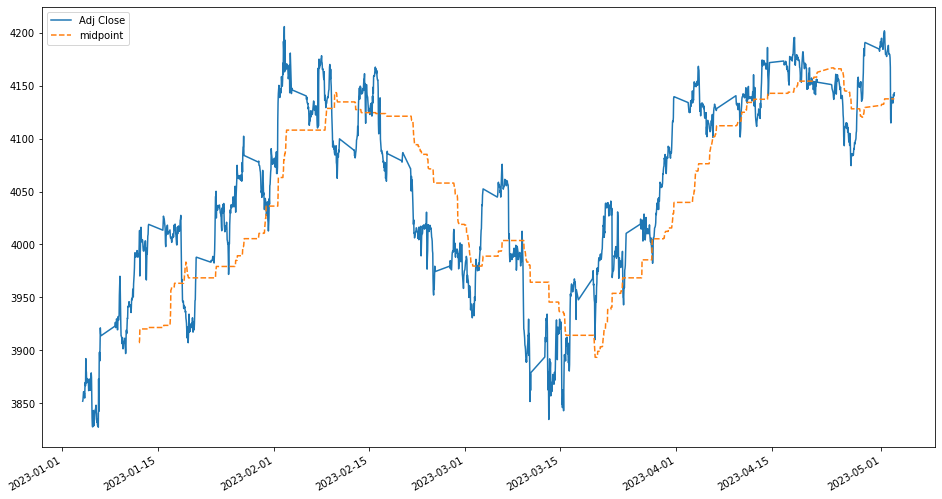

In [4]:
# Identify where midpoint is between higher highs and lower lows
df['midpoint'] = (df['higher_highs'] +  df['lower_lows']) / 2

# Plot where midpoint is 
df['Adj Close'].plot(legend=True)
df['midpoint'].plot(style='--',legend=True)


<AxesSubplot:>

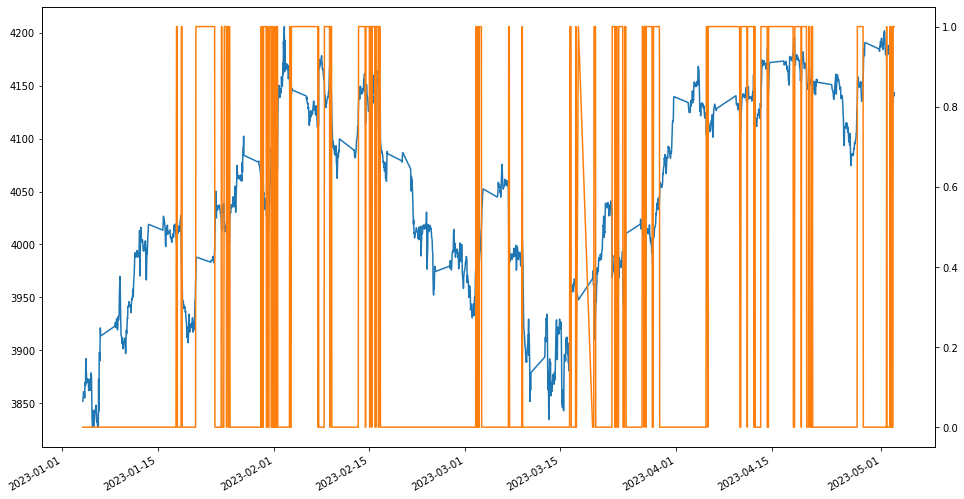

In [5]:
# Generate a signal where you buy when Close price passes the midpoint, sell 1% above it
df['signal'] = np.where(df['Adj Close'] >= (df['midpoint'].shift(1)), 1, 0)
df['signal'] = np.where(df['Adj Close'] >= (1.01*df['midpoint'].shift(1)), 0, df['signal'])

# Plot when buys would occur
df['Adj Close'].plot()
df['signal'].plot(secondary_y=True)

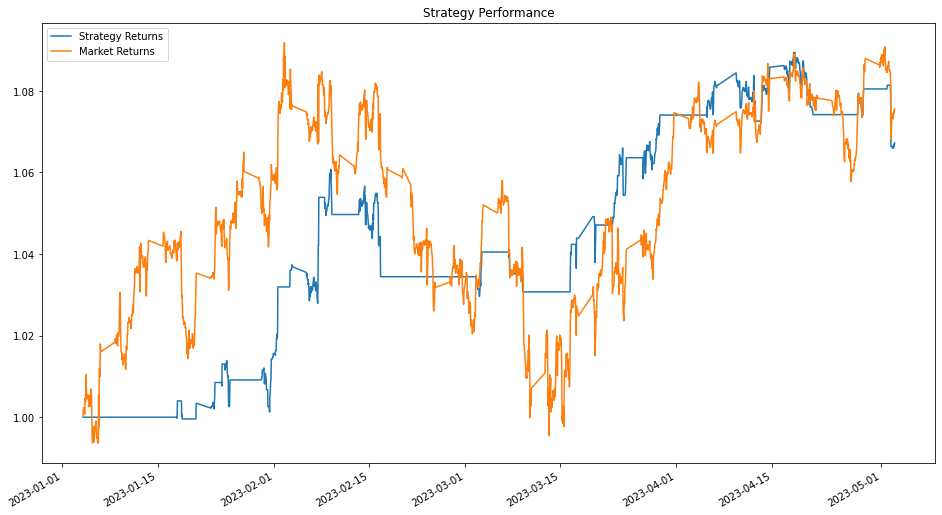

In [6]:
# Backtest returns
df['log_ret'] = df['Adj Close'].apply(np.log).diff(1)

options = [1, -1]
rslt_df = df.copy()
rslt_df['position'] = rslt_df['signal'] 
rslt_df['my_rs'] = rslt_df['position'].shift(1)*rslt_df['log_ret']

# Calculate Transaction Costs
tc_pct = 0.002 # assume transaction cost of 0.2% 
delta_pos = pd.DataFrame(rslt_df['position']).diff(1).abs().sum(1) # compute portfolio changes
my_tcs = tc_pct*delta_pos # compute transaction costs
my_rs1 = pd.DataFrame((rslt_df['position'].shift(1)*rslt_df['my_rs'])).sum(1) # don't include costs
my_rs2 = pd.DataFrame((rslt_df['position'].shift(1)*rslt_df['my_rs'])).sum(1) - my_tcs # include costs

# rslt_df['position'].plot(figsize=(16,9), label="Position", title="Position vs Price", legend=True)
# rslt_df['Adj Close'].plot(secondary_y=True, label="Close Price", legend=True)
# plt.show()

rslt_df['my_rs'].cumsum().apply(np.exp).plot(figsize=(16,9),title='Strategy Performance', legend=True, label="Strategy Returns")
rslt_df['log_ret'].cumsum().apply(np.exp).plot(legend=True, label='Market Returns')
plt.show()